In [4]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

df = pd.read_csv('../data/model_input_with_interactions.csv')  

###  New Interaction Features

In [5]:
df['diagnosis_x_severity'] = df['diagnosis_encoded'] * df['severity_encoded']
df['procedure_x_severity'] = df['procedure_encoded'] * df['severity_encoded']
df['diagnosis_x_procedure'] = df['diagnosis_encoded'] * df['procedure_encoded']
df['county_x_los'] = df['county_encoded'] * df['los']

### Feature Columns

In [6]:
feature_cols = [
    'gender_encoded', 'age_group_encoded', 'severity_encoded',
    'admission_encoded', 'payment_type_encoded', 'diagnosis_encoded',
    'procedure_encoded', 'county_encoded', 'los',
    'los_x_severity', 'los_x_procedure', 'severity_x_procedure', 'los_x_county',
    'diagnosis_x_severity', 'procedure_x_severity', 
    'diagnosis_x_procedure', 'county_x_los'
]

In [7]:
# Train-test split
X = df[feature_cols]
y = np.log1p(df['total_charges'])  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Train model
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2544
[LightGBM] [Info] Number of data points in the train set: 1873243, number of used features: 17
[LightGBM] [Info] Start training from score 10.142437


LGBMRegressor(learning_rate=0.05, n_estimators=1000)

### Evaluate Performance 

In [9]:
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

mae = mean_absolute_error(y_actual, y_pred)
print(f"New LightGBM MAE with interaction features: ${mae:,.2f}")

New LightGBM MAE with interaction features: $13,057.92


## Residual Group Analysis

### Top Diagnoses

In [ ]:
# Load diagnosis mapping
diag_map = pd.read_csv('../data/diagnosis_mapping.csv')

# Merge readable diagnosis
labeled = labeled.merge(diag_map, on='diagnosis_encoded', how='left')

In [ ]:
# Copy from df
labeled = df.copy()

# Merge readable diagnosis names
labeled = labeled.merge(diag_map, on='diagnosis_encoded', how='left')

# Generate predictions and residuals
labeled['model_prediction'] = model.predict(labeled[feature_cols])
labeled['residual'] = labeled['total_charges'] - labeled['model_prediction']

# Group
res_by_diag = (
    labeled.groupby('ccs_diagnosis_description')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .query('count >= 5')
    .sort_values(by='avg_residual', ascending=False)
)

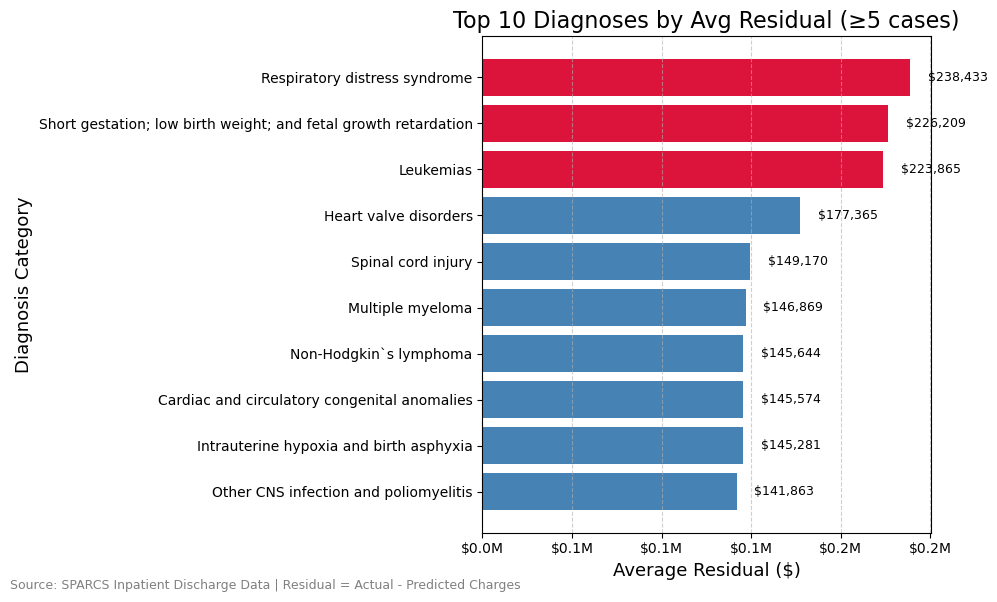

In [43]:
# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Filter and sort top 10 diagnoses
top_10 = res_by_diag.head(10).sort_values('avg_residual')

# Optional: Emphasize extreme residuals in red
colors = ['crimson' if x > 200000 else 'steelblue' for x in top_10['avg_residual']]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(top_10.index, top_10['avg_residual'], color=colors)

# Format x-axis as dollars in millions
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Add data labels to bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 10000, bar.get_y() + bar.get_height() / 2,
            f'${width:,.0f}', va='center', fontsize=9)

# Titles and labels
ax.set_title('Top 10 Diagnoses by Avg Residual (≥5 cases)', fontsize=16)
ax.set_xlabel('Average Residual ($)', fontsize=13)
ax.set_ylabel('Diagnosis Category', fontsize=13)

# Gridlines for readability
ax.xaxis.grid(True, linestyle='--', alpha=0.6)

# Source note
plt.figtext(0.01, 0.01, 'Source: SPARCS Inpatient Discharge Data | Residual = Actual - Predicted Charges', 
            fontsize=9, ha='left', color='gray')

plt.tight_layout()
plt.show()

## Top Diagnosis Groups

#### Respiratory Distress Syndrome

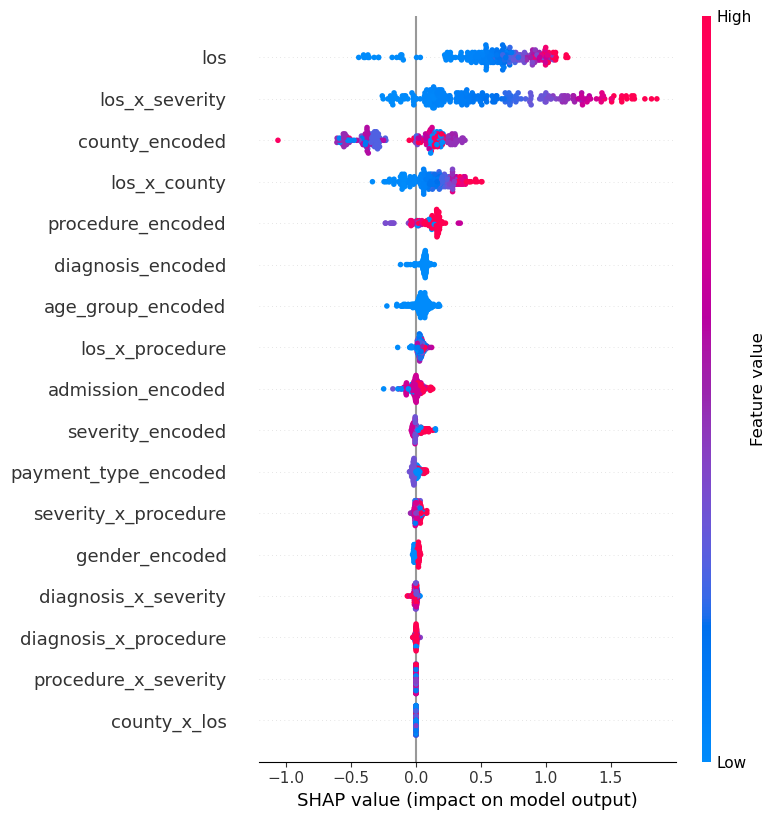

In [44]:
import shap 
explainer = shap.TreeExplainer(model)
group = labeled[labeled['ccs_diagnosis_description'] == 'Respiratory distress syndrome']
shap_values = explainer(group[feature_cols])
shap.summary_plot(shap_values, group[feature_cols])

####  Short gestation

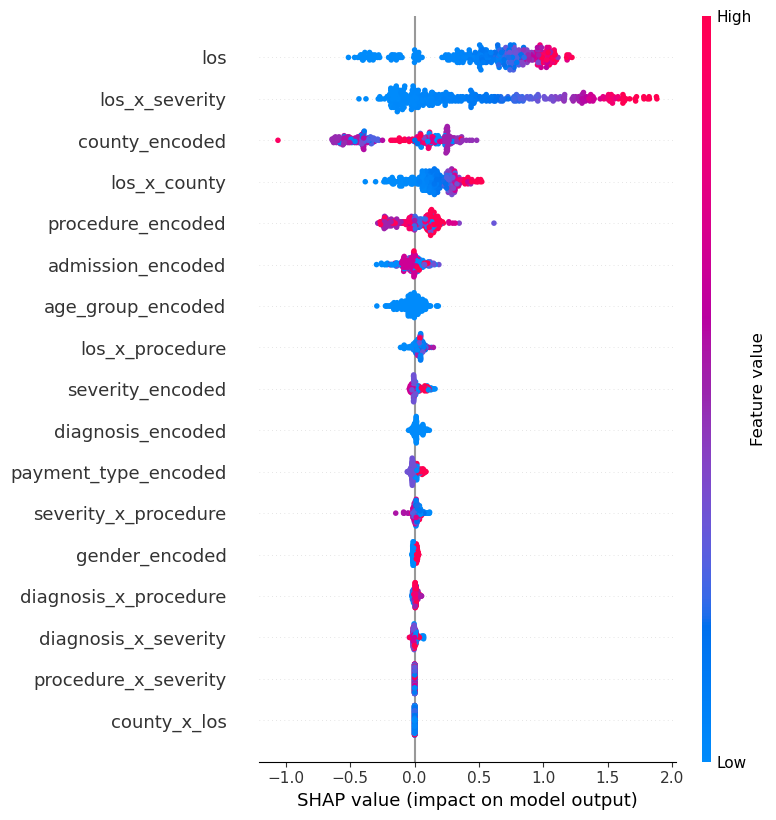

In [21]:
group = labeled[labeled['ccs_diagnosis_description'] == 'Short gestation; low birth weight; and fetal growth retardation']
shap_values = explainer(group[feature_cols])
shap.summary_plot(shap_values, group[feature_cols])

#### Leukemia

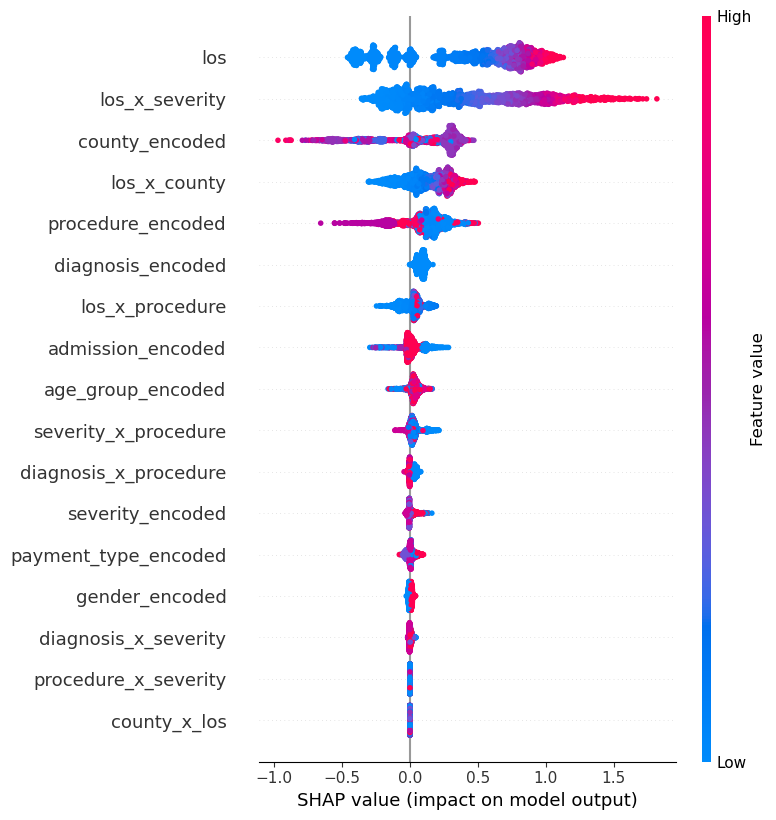

In [22]:
group = labeled[labeled['ccs_diagnosis_description'] == 'Leukemias']
shap_values = explainer(group[feature_cols])
shap.summary_plot(shap_values, group[feature_cols])

## Diagnosis-Based Segmented Models 

**Goal:** Train separate LightGBM models for distinct diagnosis groups (like neonatal, oncology, general) because they behave differently in cost prediction.


Define Diagnosis Segments

In [45]:
def categorize_diagnosis(desc):
    desc = desc.lower()
    
    if any(x in desc for x in ['leukemia', 'lymphoma', 'myeloma', 'neoplasm', 'cancer']):
        return 'Oncology'
    elif any(x in desc for x in ['short gestation', 'liveborn', 'fetal', 'newborn', 'neonatal']):
        return 'Neonatal'
    elif any(x in desc for x in ['schizophrenia', 'mood', 'psychotic', 'substance', 'alcohol']):
        return 'Behavioral'
    elif any(x in desc for x in ['septicemia', 'pneumonia', 'infection']):
        return 'Infectious'
    elif any(x in desc for x in ['osteoarthritis', 'spondylosis', 'back problems']):
        return 'Orthopedic'
    elif any(x in desc for x in ['diabetes', 'heart failure', 'dysrhythmia', 'myocardial', 'coronary']):
        return 'Cardio-Metabolic'
    elif any(x in desc for x in ['pregnancy', 'delivery', 'c-section', 'puerperium']):
        return 'OB/GYN'
    else:
        return 'General'
    


In [47]:
# Apply this categorization
labeled['diagnosis_group'] = labeled['ccs_diagnosis_description'].apply(categorize_diagnosis)

# Group by new column to analyze residuals
labeled.groupby('diagnosis_group')['residual'].mean().sort_values(ascending=False)

diagnosis_group
Oncology            78973.024648
Orthopedic          59224.451215
Cardio-Metabolic    55073.287488
Infectious          52765.388675
General             48388.822366
Behavioral          30493.945275
OB/GYN              21436.871384
Neonatal            20352.036798
Name: residual, dtype: float64

In [ ]:
# Add group labels to data 
df = df.merge(labeled[['diagnosis_encoded', 'diagnosis_group']].drop_duplicates(), on='diagnosis_encoded', how='left')

Prepare a Loop to Train One Model Per Group

In [51]:
from collections import defaultdict

group_models = {}
group_maes = {}

for group in df['diagnosis_group'].unique():
    group_df = df[df['diagnosis_group'] == group].copy()

    X = group_df[feature_cols]
    y = np.log1p(group_df['total_charges'])  # log-transform target

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
    model.fit(X_train, y_train)

    # Save model and MAE
    group_models[group] = model
    y_pred = np.expm1(model.predict(X_test))
    y_true = np.expm1(y_test)
    group_maes[group] = mean_absolute_error(y_true, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2544
[LightGBM] [Info] Number of data points in the train set: 833469, number of used features: 17
[LightGBM] [Info] Start training from score 10.284842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1906
[LightGBM] [Info] Number of data points in the train set: 161873, number of used features: 17
[LightGBM] [Info] Start training from score 10.396232
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [52]:
for group, mae in group_maes.items():
    print(f"{group} MAE: ${mae:,.2f}")

General MAE: $13,887.29
Cardio-Metabolic MAE: $15,608.22
Behavioral MAE: $8,045.23
Infectious MAE: $13,495.79
Oncology MAE: $21,272.01
OB/GYN MAE: $4,738.34
Neonatal MAE: $5,723.59
Orthopedic MAE: $15,956.92


In [54]:
df['group_prediction'] = np.nan  # start with blank predictions

for group in df['diagnosis_group'].unique():
    model = group_models.get(group)
    if model:
        group_idx = df['diagnosis_group'] == group
        group_X = df.loc[group_idx, feature_cols]
        preds = np.expm1(model.predict(group_X))
        df.loc[group_idx, 'group_prediction'] = preds

In [55]:
overall_grouped_mae = mean_absolute_error(df['total_charges'], df['group_prediction'])
print(f"Overall Grouped Model MAE: ${overall_grouped_mae:,.2f}")

Overall Grouped Model MAE: $12,186.01
